In [7]:
import pandas as pd
nifty_1day = pd.read_csv('../testing.csv')
nifty_1day['datetime'] =  pd.to_datetime(nifty_1day['datetime'], infer_datetime_format=True)
nifty_1day = nifty_1day.set_index("datetime")
nifty_1day = nifty_1day[nifty_1day.index >= '2011-01-03']
nifty_1day["pct_returns"] = nifty_1day["close"].pct_change()
nifty_1day["abs_returns"] = nifty_1day["close"].diff()
nifty_1day['cumsum'] = nifty_1day['abs_returns'].cumsum()
nifty_1day["cumulative_returns"] = ((1 + nifty_1day["pct_returns"]).cumprod() - 1)+1
nifty_1day["pct_returns"] = nifty_1day["pct_returns"] * 100

2011-02-22, Close, 5469.20
2011-02-22, BUY CREATE, 5469.20
2011-02-23, BUY EXECUTED, Price: 5452.45, Cost: 5452.45, Comm 0.00
2011-02-23, Close, 5437.35
2011-02-24, Close, 5262.70
2011-02-24, SELL CREATE, 5262.70
2011-02-25, SELL EXECUTED, Price: 5321.05, Cost: 5452.45, Comm 0.00
2011-02-25, OPERATION PROFIT, GROSS -131.40, NET -131.40
2011-02-25, Close, 5303.55
2011-02-28, Close, 5333.25
2011-03-01, Close, 5522.30
2011-03-01, BUY CREATE, 5522.30
2011-03-03, BUY EXECUTED, Price: 5478.45, Cost: 5478.45, Comm 0.00
2011-03-03, Close, 5536.20
2011-03-04, Close, 5538.75
2011-03-07, Close, 5463.15
2011-03-08, Close, 5520.80
2011-03-09, Close, 5531.00
2011-03-10, Close, 5494.40
2011-03-11, Close, 5445.45
2011-03-11, SELL CREATE, 5445.45
2011-03-14, SELL EXECUTED, Price: 5436.50, Cost: 5478.45, Comm 0.00
2011-03-14, OPERATION PROFIT, GROSS -41.95, NET -41.95
2011-03-14, Close, 5531.50
2011-03-14, BUY CREATE, 5531.50
2011-03-15, BUY EXECUTED, Price: 5420.00, Cost: 5420.00, Comm 0.00
2011-03-15,

c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


'figure = cerebro.plot()[0][0]\n\n# show the plot in Streamlit\nst.pyplot(figure)'

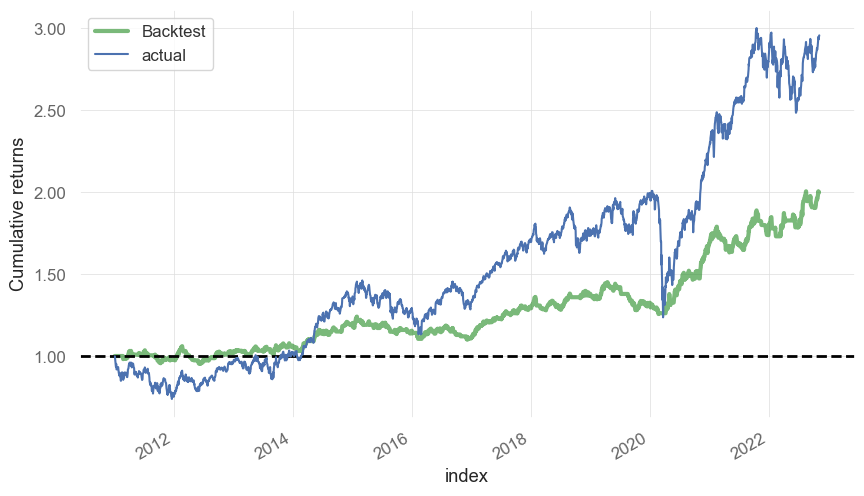

In [21]:
import pandas as pd
import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import quantstats as qs
import pyfolio as pf
import streamlit as st

class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order is not None:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns')

data = bt.feeds.YahooFinanceCSVData(
        dataname='../testing.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2011, 1, 3),
        # Do not pass values before this date
        todate=datetime.datetime(2022, 11, 7),
        # Do not pass values after this date
        reverse=False)
cerebro.adddata(data)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
results = cerebro.run()
strat = results[0]


portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
qs.reports.html(returns, output='stats.html', title='Nifty Sentiment')

# Plot the cumulative sum using Pyfolio
pf.plotting.plot_rolling_returns(returns)
plt.plot(nifty_1day['cumulative_returns'], label='actual')
plt.legend()
plt.savefig("data.png")

'''figure = cerebro.plot()[0][0]

# show the plot in Streamlit
st.pyplot(figure)'''

2011-03-29 BUY CREATE 5736.350000
2011-03-30 BUY EXECUTED, 5755.80
2011-04-06 CLOSE CREATE 5891.750000
2011-04-07 SELL EXECUTED, 5888.55
2011-05-18 SELL CREATE 5420.600000
2011-05-19 SELL EXECUTED, 5448.15
2011-05-26 CLOSE CREATE 5412.350000
2011-05-27 BUY EXECUTED, 5413.70
2011-07-12 BUY CREATE 5526.150000
2011-07-13 BUY EXECUTED, 5542.05
2011-07-20 CLOSE CREATE 5567.050000
2011-07-21 SELL EXECUTED, 5554.60
2011-08-08 SELL CREATE 5118.500000
2011-08-09 SELL EXECUTED, 4947.90
2011-08-17 CLOSE CREATE 5056.600000
2011-08-18 BUY EXECUTED, 5077.95
2011-10-25 BUY CREATE 5191.600000
2011-10-26 BUY EXECUTED, 5214.95
2011-11-04 CLOSE CREATE 5284.200000
2011-11-08 SELL EXECUTED, 5292.25
2011-11-30 SELL CREATE 4832.050000
2011-12-01 SELL EXECUTED, 4970.85
2011-12-09 CLOSE CREATE 4866.700000
2011-12-12 BUY EXECUTED, 4906.85
2012-01-23 BUY CREATE 5046.250000
2012-01-24 BUY EXECUTED, 5064.80
2012-02-01 CLOSE CREATE 5235.700000
2012-02-02 SELL EXECUTED, 5272.10
2012-03-30 SELL CREATE 5295.550000
201

c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


'plt.plot(nifty_1day[\'cumulative_returns\'], label=\'actual\')\nplt.legend()\nplt.savefig("data.png")'

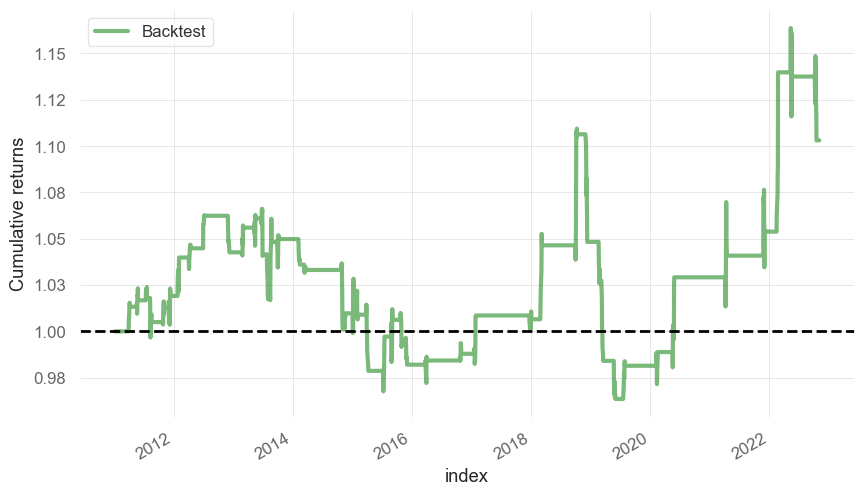

In [7]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import backtrader as bt
import backtrader.indicators as btind
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import quantstats as qs
import pyfolio as pf
import streamlit as st
import numpy as np

class MAcrossover(bt.Strategy): 
	# Moving average parameters
	params = (('pfast',20),('pslow',50),)

	def log(self, txt, dt=None):
		dt = dt or self.datas[0].datetime.date(0)
		print(f'{dt.isoformat()} {txt}') # Comment this line when running optimization

	def __init__(self):
		self.dataclose = self.datas[0].close
		
		# Order variable will contain ongoing order details/status
		self.order = None

		# Instantiate moving averages
		self.fast_sma = bt.indicators.MovingAverageSimple(self.datas[0], period=self.params.pfast)
		self.slow_sma = bt.indicators.MovingAverageSimple(self.datas[0], period=self.params.pslow)
		
		''' Using the built-in crossover indicator
		self.crossover = bt.indicators.CrossOver(self.fast_sma, self.slow_sma)'''


	def notify_order(self, order):
		if order.status in [order.Submitted, order.Accepted]:
			# An active Buy/Sell order has been submitted/accepted - Nothing to do
			return

		# Check if an order has been completed
		# Attention: broker could reject order if not enough cash
		if order.status in [order.Completed]:
			if order.isbuy():
				self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
			elif order.issell():
				self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
			self.bar_executed = len(self)

		elif order.status in [order.Canceled, order.Margin, order.Rejected]:
			self.log('Order Canceled/Margin/Rejected')

		# Reset orders
		self.order = None

	def next(self):
		''' Logic for using the built-in crossover indicator
		
		if self.crossover > 0: # Fast ma crosses above slow ma
			pass # Signal for buy order
		elif self.crossover < 0: # Fast ma crosses below slow ma
			pass # Signal for sell order
		'''

		# Check for open orders
		if self.order:
			return

		# Check if we are in the market
		if not self.position:
			# We are not in the market, look for a signal to OPEN trades
				
			#If the 20 SMA is above the 50 SMA
			if self.fast_sma[0] > self.slow_sma[0] and self.fast_sma[-1] < self.slow_sma[-1]:
				self.log(f'BUY CREATE {self.dataclose[0]:2f}')
				# Keep track of the created order to avoid a 2nd order
				self.order = self.buy()
			#Otherwise if the 20 SMA is below the 50 SMA   
			elif self.fast_sma[0] < self.slow_sma[0] and self.fast_sma[-1] > self.slow_sma[-1]:
				self.log(f'SELL CREATE {self.dataclose[0]:2f}')
				# Keep track of the created order to avoid a 2nd order
				self.order = self.sell()
		else:
			# We are already in the market, look for a signal to CLOSE trades
			if len(self) >= (self.bar_executed + 5):
				self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
				self.order = self.close()

cerebro = bt.Cerebro()

data = bt.feeds.YahooFinanceCSVData(
        dataname='../testing.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2011, 1, 3),
        # Do not pass values before this date
        todate=datetime.datetime(2022, 11, 7),
        # Do not pass values after this date
        reverse=False)

cerebro.adddata(data)
cerebro.addstrategy(MAcrossover)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
qs.reports.html(returns, output='stats.html', title='Nifty Sentiment')

'''data = cerebro.plot()
data[0][0].savefig("data1.png")'''

# Plot the cumulative sum using Pyfolio
pf.plotting.plot_rolling_returns(returns)
'''plt.plot(nifty_1day['cumulative_returns'], label='actual')
plt.legend()
plt.savefig("data.png")'''

c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


'plt.plot(nifty_1day[\'cumulative_returns\'], label=\'actual\')\nplt.legend()\nplt.savefig("data.png")'

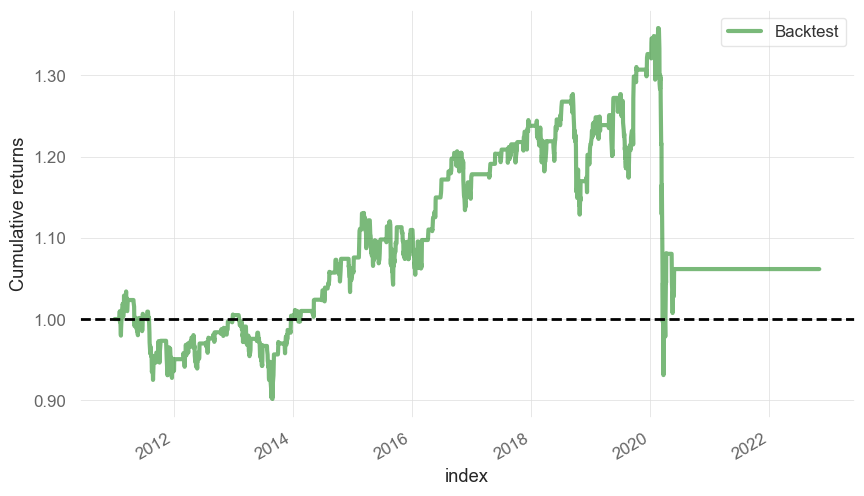

In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import backtrader as bt
import backtrader.indicators as btind
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import quantstats as qs
import pyfolio as pf
import streamlit as st
import numpy as np

class MeanReversion(bt.Strategy):
    params = (
        ('period', 20),
        ('deviation', 2),
    )

    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.period
        )
        self.order = None

    def next(self):
        if not self.position:
            if self.data.close < self.sma[0] - self.params.deviation:
                self.order = self.buy()
        else:
            if self.data.close > self.sma[0] + self.params.deviation:
                self.close()
                self.order = None

cerebro = bt.Cerebro()

data = bt.feeds.YahooFinanceCSVData(
        dataname='../testing.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2011, 1, 3),
        # Do not pass values before this date
        todate=datetime.datetime(2022, 11, 7),
        # Do not pass values after this date
        reverse=False)

cerebro.adddata(data)
cerebro.addstrategy(MeanReversion)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
qs.reports.html(returns, output='stats.html', title='Nifty Sentiment')

'''data = cerebro.plot()
data[0][0].savefig("data1.png")'''

# Plot the cumulative sum using Pyfolio
pf.plotting.plot_rolling_returns(returns)
'''plt.plot(nifty_1day['cumulative_returns'], label='actual')
plt.legend()
plt.savefig("data.png")'''